# Feature Detection and Description

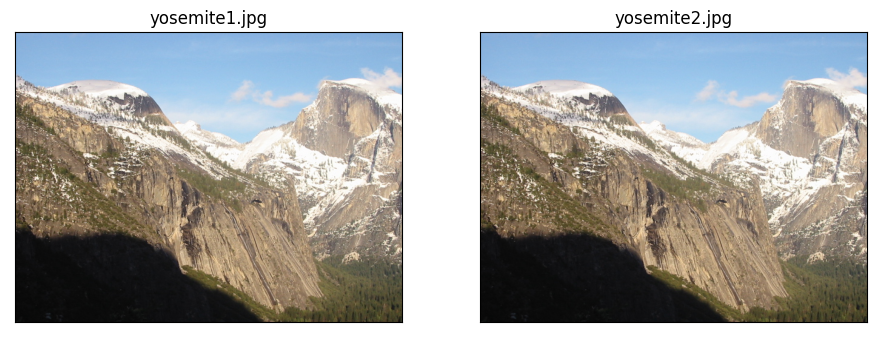

In [41]:
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('yosemite/yosemite1.jpg')
img2 = cv2.imread('yosemite/yosemite2.jpg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

gs1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gs2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

fig1, ax = plt.subplots(1, 2, figsize=(11, 6))

ax[0].imshow(img1)
ax[0].set_title('yosemite1.jpg'), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(img1)
ax[1].set_title('yosemite2.jpg'), ax[1].set_xticks([]), ax[1].set_yticks([])
plt.show()

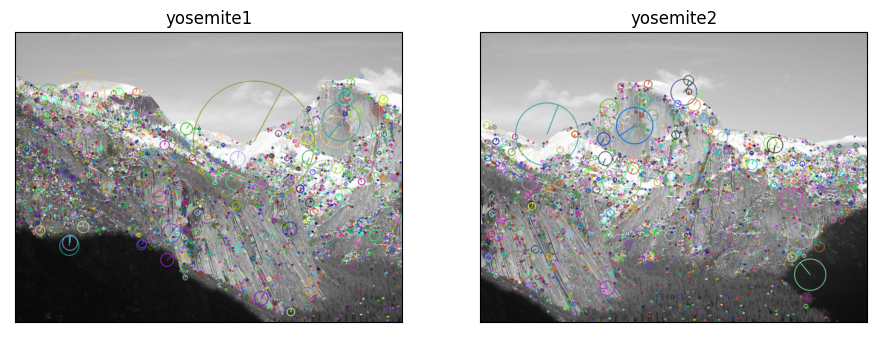

In [158]:
# Initiate SIFT detector
fig2, ax = plt.subplots(1, 2, figsize=(11, 6))

def create_keypoints(img):
    """
    Create keypoints and descriptors for a greyscale image
    :param img:
    :return: Keypoints and descriptors
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def display_keypoints(img, kp):
    """
    Draw keypoints on an image
    :param img: image to draw keypoints on
    :param kp: Keypoints to draw
    :return: Image with keypoints drawn
    """
    return cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

kp1, des1 = create_keypoints(gs1)
draw1 = display_keypoints(gs1, kp1)
ax[0].imshow(draw1)
ax[0].set_title('yosemite1'), ax[0].set_xticks([]), ax[0].set_yticks([])

kp2, des2 = create_keypoints(gs2)
draw2 = display_keypoints(gs2, kp2)
ax[1].imshow(draw2)
ax[1].set_title('yosemite2'), ax[1].set_xticks([]), ax[1].set_yticks([])

plt.show()

# Feature Matching

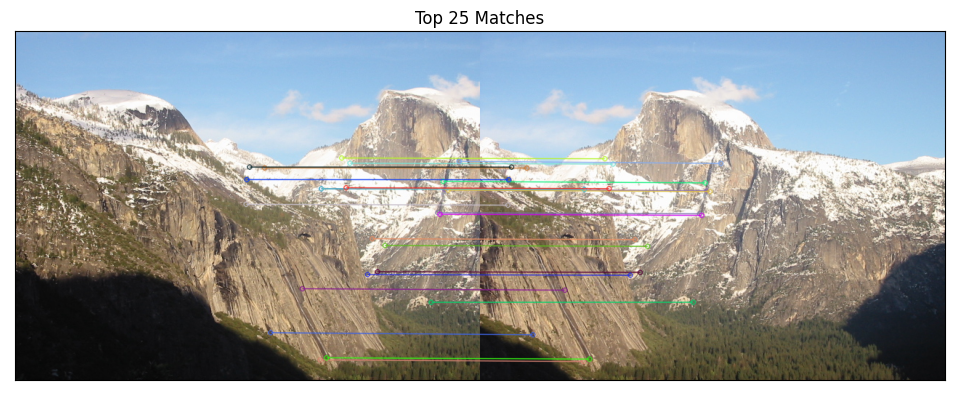

In [176]:
# Initiate matcher
top_n = 25

def match_features(des1, des2):
    """
    Match features between two images
    :param des1: Descriptors for image 1
    :param des2: Descriptors for image 2
    :return: Matches
    """
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    return matches

def draw_n_matches(img1, kp1, img2, kp2, matches, n):
    """
    Draw the top n matches between two images
    :param img1: Image 1
    :param kp1: Keypoints for image 1
    :param img2: Image 2
    :param kp2: Keypoints for image 2
    :param matches: Matches between the two images
    :param n: Number of matches to draw
    :return: Image with matches drawn
    """
    return cv2.drawMatches(img1, kp1, img2, kp2, matches[:n], None, flags=2)

matches = match_features(des1, des2)
img3 = draw_n_matches(img1, kp1, img2, kp2, matches, top_n)

fig3, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.imshow(img3)
ax.set_title(f'Top {top_n} Matches'), ax.set_xticks([]), ax.set_yticks([])
plt.show()

In [178]:
# Construct correspondences
import numpy as np

def construct_correspondences(kp1, kp2, matches):
    """
    Construct correspondences between two images
    :param kp1: Keypoints for image 1
    :param kp2: Keypoints for image 2
    :param matches: Matches between the two images
    :return: Correspondences
    """
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])
    return pts1, pts2

# Sanity check
pts1, pts2 = construct_correspondences(kp1, kp2, matches)
print(f"Sizes of correspondences: {pts1.shape}, {pts2.shape}")

# Warp image based off the homography transformation using RANSAC
def ransac_homography(pts1, pts2):
    """
    Warp image based off the homography transformation using RANSAC
    :param img1: Image 1
    :param img2: Image 2
    :param pts1: Correspondences for image 1
    :param pts2: Correspondences for image 2
    :return: Warped image
    """
    h, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)
    return h, mask

homography, mask = ransac_homography(pts1, pts2)

Sizes of correspondences: (2504, 2), (2504, 2)


# Image Blending

In [179]:
from scipy.ndimage import distance_transform_edt

def get_distance_transform(img_rgb):
    """
    Get distance to the closest background pixel for an RGB image
    Input:
        img_rgb: np.array , HxWx3 RGB image
    Output:
        dist: np.array , HxWx1 distance image
            each pixel’s intensity is proportional to
            its distance to the closest background pixel
            scaled to [0..255] for plotting
     """
    threshold = cv2.threshold(img_rgb, 0, 255, cv2.THRESH_BINARY)[1]
    threshold = threshold.any(axis=2)
    threshold = np.pad(threshold, 1)
    dist = distance_transform_edt(threshold)[1:-1, 1:-1]
    dist = dist[:, :, None]
    return dist / dist.max() * 255.0

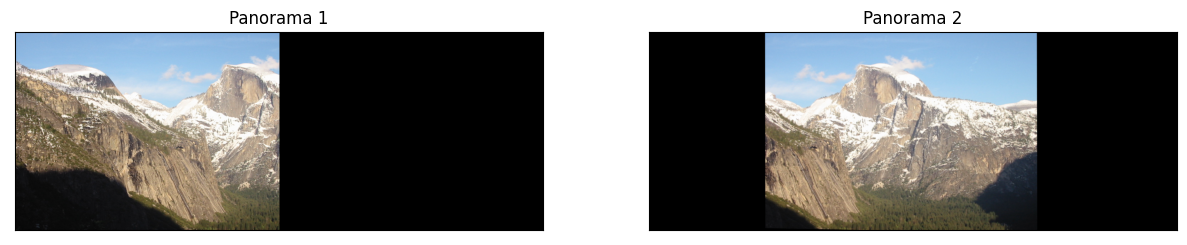

In [180]:
width_panorama, height_panorama = img1.shape[1] + img2.shape[1], img1.shape[0]

panorama1 = np.zeros((height_panorama, width_panorama, 3))
panorama1[:img1.shape[0], :img1.shape[1], :] = img1
panorama1 = panorama1 * 255.0 / panorama1.max()

panorama2 = cv2.warpPerspective(img2, homography, (width_panorama, height_panorama))
panorama2 = panorama2 * 255.0 / panorama2.max()

fig4, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(panorama1.astype(np.uint8))
ax[0].set_title('Panorama 1'), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(panorama2.astype(np.uint8))
ax[1].set_title('Panorama 2'), ax[1].set_xticks([]), ax[1].set_yticks([])
plt.show()

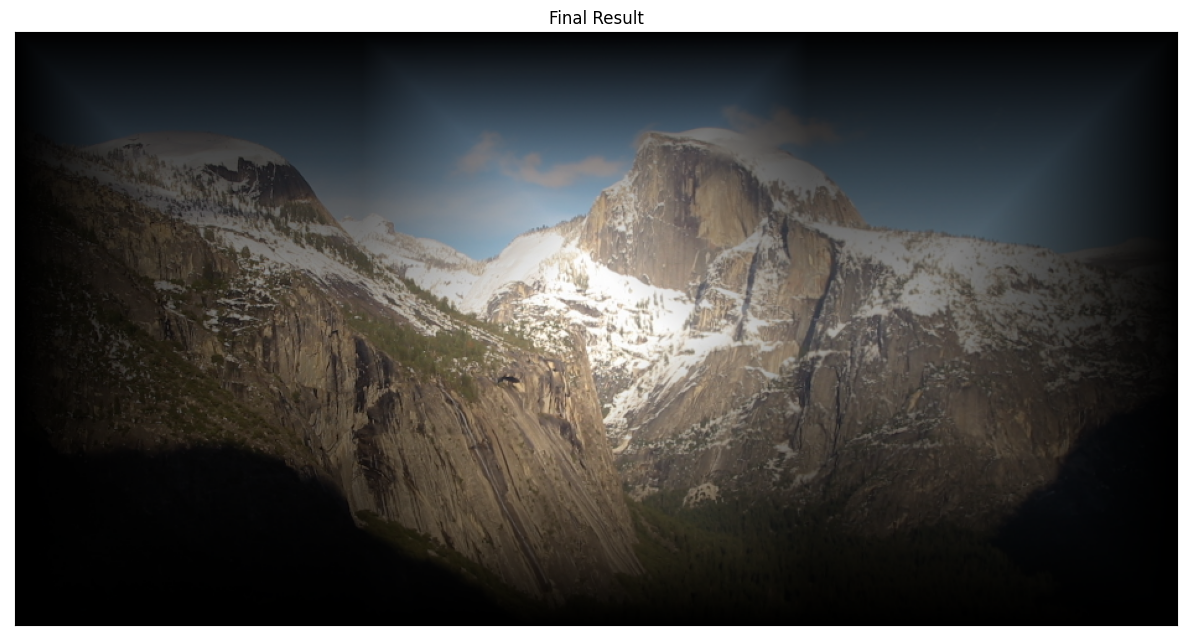

In [181]:
# Plot final result
result = panorama1 * get_distance_transform(panorama1) + panorama2 * get_distance_transform(panorama2)

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows)
min_col, max_col = min(cols), max(cols)

final_result = result[min_row:max_row, min_col:max_col, :]
final_result_normalized = final_result * 255.0 / final_result.max()

fig5, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(final_result_normalized.astype(np.uint8))
ax.set_title('Final Result'), ax.set_xticks([]), ax.set_yticks([])
plt.show()

# Stitching Multiple Images

In [153]:
import os

def get_image_paths(directory):
    """
    Get all image paths in a directory
    Input:
        directory: str, directory path
    Output:
        image_paths: list of str, list of image paths
    """
    image_paths = []
    for file in os.listdir(directory):
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(directory, file))
    return image_paths

print(get_image_paths('yosemite/'))

['yosemite/yosemite1.jpg', 'yosemite/yosemite2.jpg', 'yosemite/yosemite3.jpg', 'yosemite/yosemite4.jpg']
